# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "clement"
ln1 = "hardy"
fn2 = "felix"
ln2 = "larrouy"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_hardy_clement_and_larrouy_felix.ipynb


In [3]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
# choose a large font size by default and use tex for math
usetex = False  # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize - 3,
          'axes.titlesize': fontsize + 4,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'text.usetex': usetex}
plt.rcParams.update(params)

In [4]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [5]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [6]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)
    residuals = b - A.dot(w)

    lips_const = np.linalg.norm(A, axis=0) ** 2

    for t in range(n_iter):
        j = t % n_features
        old_w_j = w[j]
        w[j] += A[:, j].T.dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:, j].dot(old_w_j - w[j])

        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)


def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)

    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date

    lips_const = np.linalg.norm(A, axis=0) ** 2

    for t in range(n_iter):
        # choose feature j to update:
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient += gram[:, j].dot(w[j] - old_w_j)

        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)

    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

### Compute a precise minimum with your favorite solver

Here we use BFGS solver from scipy.

In [7]:
from scipy.optimize import fmin_l_bfgs_b


def loss(w, A, b):
    return np.linalg.norm(A.dot(w) - b) ** 2 / 2


def grad(w, A, b):
    return A.T.dot(A.dot(w) - b)


x_init = np.zeros(n_features)
x_min, f_min, _ = fmin_l_bfgs_b(
    loss, x_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)

### Compare the performance of cyclic and greedy CD

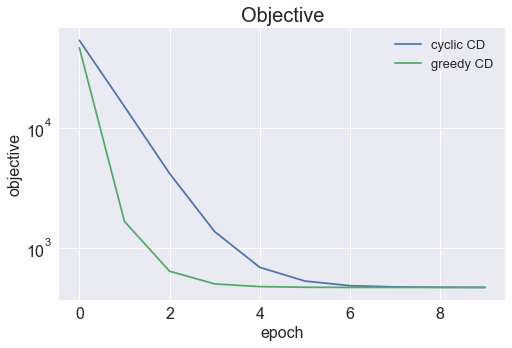

In [8]:
w_cyclic, all_objs_cyclic = cyclic_cd(A, b, 1000)
w_greedy, all_objs_greedy = greedy_cd(A, b, 1000)

plt.figure(figsize=(8, 5))
plt.semilogy(all_objs_cyclic, label="cyclic CD")
plt.semilogy(all_objs_greedy, label="greedy CD")
plt.title('Objective')
plt.xlabel('epoch')
plt.ylabel('objective')
plt.legend()

**Comments**

We can observe that both cyclic CD and greedy CD are converging but it takes less epochs to greedy CD to stabilize (around 4), while it takes around 6 epochs for cyclic CD.

### Could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

The computation in the case of OLS with 100.000 features seems to be difficult, the convergence aren't necessary possible.
The causes are that in high dimensions the function isn't smooth and convex.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

Let's take $f$ as
$$
f(w)=\sum_{i=1}^nlog(1+e^{-y_iw^Tx_i})
$$

$$
\nabla f_i(w) = -\sum_{i=1}^n \frac{y_ix_i}{1 + \exp(y_i x_i^\top w)}.
$$

$$
\begin{align}
&\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1 \\
\Longleftrightarrow\ &0 \in \partial\left(\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1\right) \\
\Longleftrightarrow\ &\nabla f_i(w) \in \lambda\ \partial \Vert w \Vert_1 \\
\end{align}
$$
By taking $w=0$, we find

$$
\begin{align}
-&\nabla f_i(0) \in \lambda\ \partial \Vert w \Vert_1 \\
\Longleftrightarrow\ &\sum_{i=1}^n\frac{y_ix_i}{2} \in \ \lambda\partial \Vert w \Vert_1 \\
\Longleftrightarrow\ &\sum_{i=1}^n\frac{y_ix_i}{2\lambda} \in \ \partial \Vert w \Vert_1
\end{align}
$$

$$
\begin{align}
&||\frac{X^Ty}{2\lambda}||_{\infty}\leq 1 \\
\Longleftrightarrow &\ ||X^Ty||_{\infty}\leq \lambda \\
\Longleftrightarrow &\ \lambda_{max} \leq \lambda
\end{align}
$$
The function $f$ is strongly convex. So with the following lemme, we have that the minimun is unique and so
$$
\lambda\geq\lambda_{max} \Rightarrow \hat w = 0
$$

#### Lemme:
If $X\in R^{np}$ has entries drawn from a continuous probability distribution on $\mathbb{R}^{np}$, then for any differentiable, strictly convex function $f$, and for any $\lambda > 0$, the minimization problem has a unique solution with probability one.

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

We have
$$
\nabla f_i(w) = \sum_{i=1}^n \frac{y_ix_i}{1 + \exp(y_i x_i^\top w)}
$$
Let's find the derivative of $\nabla f_i$ by $j$.
$$
h(w)=\sum_{i=1}^n \frac{y_ix_i}{1 + \exp(y_i x_i^\top w)}
$$

$$
\begin{align}
\frac{\partial h(w)}{\partial w_j}&=\sum_{i=1}^n \frac{(y_i x_i)_j\exp(y_i x_i^\top w)\left(y_ix_i\right)_j}{\left(1 + \exp(-y_i x_i^\top w)\right)^2} \\
&=\sum_{i=1}^n \frac{y_i^2 x_ij^2\exp(y_i x_i^\top w)}{\left(1 + \exp(y_i x_i^\top w)\right)^2} \\
&=\sum_{i=1}^n \frac{x_ij^2\exp(-y_i x_i^\top w)}{\left(1 + \exp(y_i x_i^\top w)\right)^2}
\end{align}
$$
As $y_i$ is equal to 1 or $-1$ and $\frac{\exp(-y_i x_i^\top w)}{\left(1 + \exp(y_i x_i^\top w)\right)^2}=\frac{\exp(-y_i x_i^\top w)}{\left(1 + \exp(y_i x_i^\top w)\right)^2}$, we have

$$
\begin{align}
\frac{\partial h(w)}{\partial w_j}&=\sum_{i=1}^n \frac{x_ij^2\exp(x_i^\top w)}{\left(1 + \exp(x_i^\top w)\right)^2}\\
&=\sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)i}}{(1 + \mathrm{e}^{(Xw)i})^2}
\end{align}
$$

As $ \forall x\in\mathbb{R},\  \frac{\mathrm{e}^{x}}{(1 + \mathrm{e}^{x})^2}\leq\frac{1}{4}$
$$
\begin{align}
\frac{\partial h(w)}{\partial w_j}&\leq \frac{1}{4}\sum_{i=1}^n  X_{i, j}^2 \\
&\leq \frac{1}{4}\Vert X_j \Vert^2
\end{align}
$$

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$\sum_i  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)i}}{(1 + \mathrm{e}^{(Xw)i})^2}$$
    
As we can see above, the derivative is equal to $\sum_i  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)i}}{(1 + \mathrm{e}^{(Xw)i})^2}$,
and this constant is better has it's smaller than the Lipschitz constant.

Implement it in the code with a `better_lc` parameter, and compare.

In [9]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord=np.inf) / 2.
lamb = lambda_max / 10.
# much easier to parametrize lambda as a function of lambda_max than
# to take random values like 0.1 in previous Labs


def lip_logreg(A):
    """Lipschitz constant for logistic loss"""
    return np.linalg.norm(A, ord=2) ** 2 / 4


def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(x) * np.maximum(0, np.abs(x) - s)


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

### Cyclic proximal coordinate descent for sparse Logistic regression

In [10]:
def cd_logreg(w_init, X, y, lamb, n_iter, better_lc=False):
    n_samples, n_features = X.shape
    w = w_init.copy()
    all_objs = np.zeros(n_iter + 1)
    lips_const = np.zeros(n_features)
    Xw = X.dot(w)

    all_objs[0] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)

    if not better_lc:
        lips_const = (np.linalg.norm(X, axis=0) ** 2) / 4

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            grad_j = np.sum(- y * X[:, j] * sigmoid(-y * Xw))

            if better_lc:
                # update Lipschitz constant
                lips_const = np.sum(X[:, j] ** 2 * np.exp(Xw) / (1 + np.exp(Xw)) ** 2)
                w[j] = prox_lasso(w[j] - grad_j / lips_const, lamb/lips_const)
            else:
                w[j] = prox_lasso(w[j] - grad_j / lips_const[j], lamb / lips_const[j])
                
            if old_w_j != w[j]:
                Xw += X[:, j].dot(w[j] - old_w_j)
                
        all_objs[t+1] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)

    return w, all_objs

#### Compare the performance with usual Lipschitz constant and with better constant

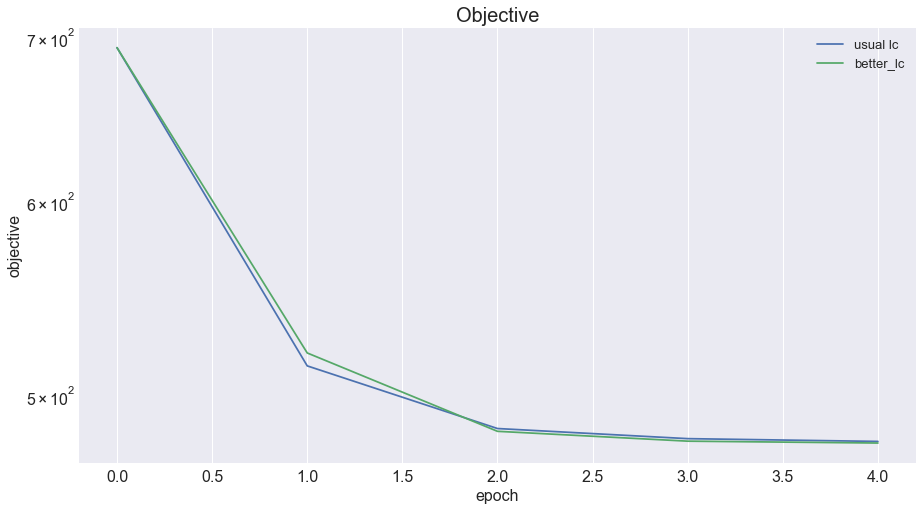

In [11]:
n_samples, n_features = X.shape
w_init = np.zeros(n_features)

step_log = 1. / lip_logreg(X)
w_cd_logreg, all_objs_cd_logreg = cd_logreg(
    w_init=w_init, X=X, y=y, lamb=lamb, n_iter=4, better_lc=False)

w_cd_logreg_better, all_objs_cd_logreg_better = cd_logreg(
    w_init=w_init, X=X, y=y, lamb=lamb, n_iter=4, better_lc=True)

plt.figure(figsize=(15, 8))
plt.semilogy(all_objs_cd_logreg, label="usual lc")
plt.semilogy(all_objs_cd_logreg_better, label="better_lc")
plt.title('Objective')
plt.xlabel('epoch')
plt.ylabel('objective')
plt.legend()

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

**Data**

In [4]:
df_leukemia = pd.read_csv('leukemia_big.csv')
df_leukemia.head()

,ALL,ALL.1,ALL.2,ALL.3,ALL.4,ALL.5,ALL.6,ALL.7,ALL.8,ALL.9,...,AML.15,AML.16,AML.17,AML.18,AML.19,AML.20,AML.21,AML.22,AML.23,AML.24
0,-1.533622,-0.867610,-0.433172,-1.671903,-1.187689,-1.127234,-1.045409,-0.106917,-1.198796,-1.190899,...,-0.436650,-1.274708,-0.681458,-0.876610,-0.624022,-0.431628,-1.435259,-0.671954,-1.013161,-0.969482
1,-1.235673,-1.275501,-1.184492,-1.596424,-1.335256,-1.113730,-0.800880,-0.745177,-0.849312,-1.190899,...,-0.915483,-1.354363,-0.653559,-1.096250,-1.066594,-1.335256,-1.204586,-0.751457,-0.889592,-1.080988
2,-0.333983,0.375927,-0.459196,-1.422571,-0.797493,-1.362768,-0.671954,-1.175674,0.320813,0.646610,...,-0.736156,-0.022153,-0.037455,-0.567335,-1.100749,-0.552938,-0.948874,-0.231657,-0.742163,-0.779500
3,0.488702,0.444011,0.436264,0.193353,0.235632,-0.360312,0.184941,0.425653,0.333983,0.235270,...,0.083781,0.356562,0.416241,0.533986,0.227505,0.416816,0.408202,0.326556,0.361813,0.298864
4,-1.300893,-1.229660,-1.325882,-1.818329,-1.311206,-1.513975,-1.651624,-1.339555,-0.593132,0.133302,...,-1.547444,-1.264475,-1.512318,-1.469583,-1.283472,-0.977672,-1.090178,-1.545120,-1.174272,-1.443183


**Defining X and y**

In [6]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T
print('There are {0} patients and {1} genes.'.format(X.shape[0], X.shape[1]))
print(y[::10])

There are 72 patients and 7128 genes.
[ 1  1 -1 -1  1  1  1 -1]


In [13]:
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.
n_samples, n_features = X.shape

Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

In [14]:
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x, ord=1)

### Functions for Ordinary Least Square

In [15]:
def grad_ols(x, Xw):
    return - X.T.dot(y - X.dot(x))


def loss_ols(x, Xw):
    return np.linalg.norm(y - X.dot(x), ord=2) ** 2 / 2.


def lip_ols(X):
    return np.linalg.norm(X, ord=2) ** 2


def grad_j_ols(X, y, Xw, j):
    return - X[:, j].dot(y-Xw)


def lip_ols_j(X):
    return np.linalg.norm(X, axis=0) ** 2

**ISTA algorithm**

In [16]:
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = X.shape

    # objective history
    objectives = []
    # Current objective
    Xw = X.dot(x)
    obj = f(x, Xw) + g(x, s)
    objectives.append(obj)
    
    for k in range(n_iter):
        x = prox_g(x - step * grad_f(x, Xw), s * step)
        Xw = X.dot(x)
        obj = f(x, Xw) + g(x, s)
        
        objectives.append(obj)
        
    return x, objectives

**Proximal CD with OLS**

In [17]:
def cd(w_init, lips_const, f, grad_f, g, prox_g, X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = w_init.copy()

    Xw = X.dot(w)

    all_objs = np.zeros(n_iter + 1)
    all_objs[0] = f(w, Xw) + g(w, lamb)

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]

            grad_j = grad_f(X, y, Xw, j)
            w[j] = prox_g(w[j] - grad_j / lips_const[j], lamb / lips_const[j])
            
            if old_w_j != w[j]:
                Xw += X[:, j].dot(w[j] - old_w_j)
                
        all_objs[t+1] = f(w, Xw) + g(w, lamb)

    return w, all_objs

**Running ISTA and Proximal CD with OLS**

In [20]:
step_ols = 1. / lip_ols(X)
n_iter = 30
w0 = np.zeros(n_features)
w_ista_ols, obj_ista_ols = ista(x0=w0, f=loss_ols, grad_f=grad_ols, g=lasso, prox_g=prox_lasso,
                                step=step_ols, s=lambd, n_iter=n_iter)

w_cd_ols, all_objs_cd_ols = cd(w_init=w0, lips_const=lip_ols_j(
    X), f=loss_ols, grad_f=grad_j_ols, g=lasso, prox_g=prox_lasso, X=X, y=y, lamb=lambd, n_iter=n_iter)

**Comparison**

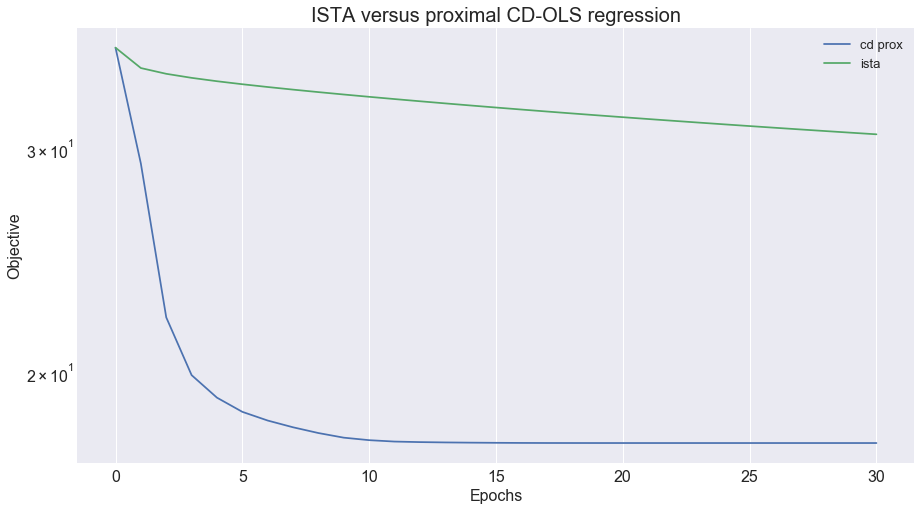

In [21]:
plt.figure(figsize=(15, 8))

plt.semilogy(all_objs_cd_ols, label="cd prox")
plt.semilogy(obj_ista_ols, label="ista")
plt.title('ISTA versus proximal CD-OLS regression')
plt.ylabel('Objective')
plt.xlabel('Epochs')
plt.legend()

plt.show()

The proximal CD solver is way faster than the ista.